In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 43283460.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66339372.30it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22450548.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3234385.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1], Sigma: 0.1, Loss: 0.0309
Epoch [2], Sigma: 0.1, Loss: 0.0090
Epoch [3], Sigma: 0.1, Loss: 0.0075
Epoch [4], Sigma: 0.1, Loss: 0.0068
Epoch [5], Sigma: 0.1, Loss: 0.0063
Epoch [6], Sigma: 0.1, Loss: 0.0060
Epoch [7], Sigma: 0.1, Loss: 0.0058
Epoch [8], Sigma: 0.1, Loss: 0.0056
Epoch [9], Sigma: 0.1, Loss: 0.0055
Epoch [10], Sigma: 0.1, Loss: 0.0054
Epoch [1], Sigma: 0.5, Loss: 0.0353
Epoch [2], Sigma: 0.5, Loss: 0.0152
Epoch [3], Sigma: 0.5, Loss: 0.0138
Epoch [4], Sigma: 0.5, Loss: 0.0132
Epoch [5], Sigma: 0.5, Loss: 0.0128
Epoch [6], Sigma: 0.5, Loss: 0.0125
Epoch [7], Sigma: 0.5, Loss: 0.0123
Epoch [8], Sigma: 0.5, Loss: 0.0122
Epoch [9], Sigma: 0.5, Loss: 0.0120
Epoch [10], Sigma: 0.5, Loss: 0.0119
Epoch [1], Sigma: 1.0, Loss: 0.0465
Epoch [2], Sigma: 1.0, Loss: 0.0297
Epoch [3], Sigma: 1.0, Loss: 0.0277
Epoch [4], Sigma: 1.0, Loss: 0.0268
Epoch [5], Sigma: 1.0, Loss: 0.0265
Epoch [6], Sigma: 1.0, Loss: 0.0261
Epoch [7], Sigma: 1.0, Loss: 0.0259
Epoch [8], Sigma: 1.0, Los

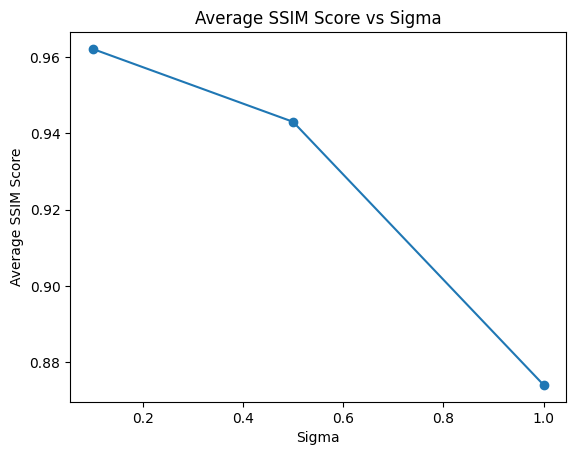

Epoch [1], Bottleneck Dim: 16, Loss: 0.0438
Epoch [2], Bottleneck Dim: 16, Loss: 0.0224
Epoch [3], Bottleneck Dim: 16, Loss: 0.0197
Epoch [4], Bottleneck Dim: 16, Loss: 0.0184
Epoch [5], Bottleneck Dim: 16, Loss: 0.0177
Epoch [6], Bottleneck Dim: 16, Loss: 0.0172
Epoch [7], Bottleneck Dim: 16, Loss: 0.0169
Epoch [8], Bottleneck Dim: 16, Loss: 0.0166
Epoch [9], Bottleneck Dim: 16, Loss: 0.0164
Epoch [10], Bottleneck Dim: 16, Loss: 0.0162
Epoch [1], Bottleneck Dim: 32, Loss: 0.0372
Epoch [2], Bottleneck Dim: 32, Loss: 0.0156
Epoch [3], Bottleneck Dim: 32, Loss: 0.0140
Epoch [4], Bottleneck Dim: 32, Loss: 0.0132
Epoch [5], Bottleneck Dim: 32, Loss: 0.0128
Epoch [6], Bottleneck Dim: 32, Loss: 0.0125
Epoch [7], Bottleneck Dim: 32, Loss: 0.0123
Epoch [8], Bottleneck Dim: 32, Loss: 0.0122
Epoch [9], Bottleneck Dim: 32, Loss: 0.0120
Epoch [10], Bottleneck Dim: 32, Loss: 0.0119
Epoch [1], Bottleneck Dim: 64, Loss: 0.0316
Epoch [2], Bottleneck Dim: 64, Loss: 0.0135
Epoch [3], Bottleneck Dim: 64,

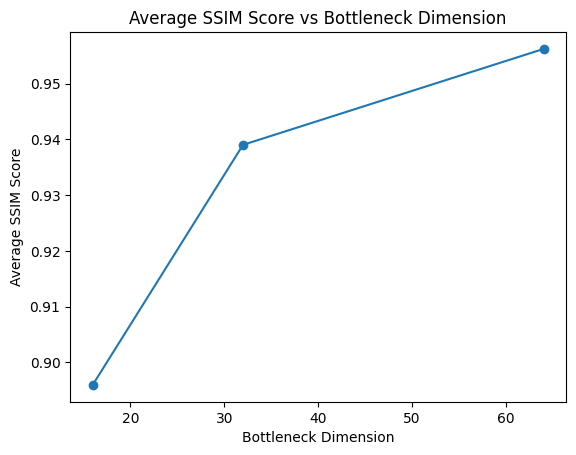

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        self.fc = nn.Linear(32*7*7, bottleneck_dim)
        self.fc_inv = nn.Linear(bottleneck_dim, 32*7*7)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        encoded = self.fc(x)
        x = self.fc_inv(encoded)
        x = x.view(-1, 32, 7, 7)
        x = self.decoder(x)
        return x, encoded

def add_gaussian_noise(image, sigma):
    noise = torch.randn_like(image) * sigma
    noisy_image = image + noise
    return noisy_image



def calculate_ssim(original, reconstructed):
    original = original.detach().numpy().squeeze()
    reconstructed = reconstructed.detach().numpy().squeeze()
    return ssim(original, reconstructed)


def train_model(model, train_loader, criterion, optimizer, sigma):
    model.train()
    total_loss = 0.0
    for data in train_loader:
        images, _ = data
        noisy_images = add_gaussian_noise(images, sigma)
        optimizer.zero_grad()
        outputs, _ = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test_model(model, test_loader):
    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for data in test_loader:
            images, _ = data
            outputs, _ = model(images)
            ssim_score = calculate_ssim(images, outputs)
            ssim_scores.append(ssim_score)
    return np.mean(ssim_scores)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
batch_size = 64
sigma_values = [0.1, 0.5, 1.0]
bottleneck_dims = [16, 32, 64]

sigma_ssim_scores = []
bottleneck_ssim_scores = []


for sigma in sigma_values:

    model = Autoencoder(bottleneck_dim=32).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, sigma)
        print(f"Epoch {epoch+1}, Sigma: {sigma}, Loss: {train_loss:.4f}")


    test_ssim_score = test_model(model, test_loader)
    sigma_ssim_scores.append(test_ssim_score)

plt.plot(sigma_values, sigma_ssim_scores, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs Sigma')
plt.show()


for bottleneck_dim in bottleneck_dims:

    model = Autoencoder(bottleneck_dim=bottleneck_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, sigma=0.5)  # Using sigma=0.5
        print(f"Epoch [{epoch+1}], Bottleneck Dim: {bottleneck_dim}, Loss: {train_loss:.4f}")


    test_ssim_score = test_model(model, test_loader)
    bottleneck_ssim_scores.append(test_ssim_score)


plt.plot(bottleneck_dims, bottleneck_ssim_scores, marker='o')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs Bottleneck Dimension')
plt.show()


As sigma increases, indicating higher levels of Gaussian noise added to the images during training, the average SSIM score tends to decrease. This observation aligns with the intuition that higher levels of noise degrade the quality of reconstructed images, leading to lower SSIM scores.
Increasing the bottleneck dimensionality generally improves the average SSIM score. This indicates that a higher-dimensional bottleneck allows the model to capture more information during the compression phase, resulting in better reconstruction quality.